In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('error')


In [41]:
filepath = os.path.join(os.getcwd(), "../data/Interim_Report.csv")
df = pd.read_csv(filepath)
df['Class'] = df['Class'].apply(lambda val: 0 if val == 'Benign' else 1)
df = shuffle(df, random_state = 1)

In [42]:
X = df.drop('Class', axis=1)
y = df.loc[:,'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
random_state=1, stratify=y)

In [43]:
print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (4414, 64)
X_test shape (2944, 64)
y_train shape (4414,)
y_test shape (2944,)


In [58]:
# Checking the range of parameters
max_depth = [2,4,6,8,10,12,14]
max_leaf_nodes= [4,6,8,10,12,14,16,18,20]
min_samples_split =  [10,20,30,40,50,60,70,80,90,100]

train_accuracy = []
test_accuracy = []

for par in min_samples_split:
    clf = RandomForestClassifier(
        criterion='gini', 
        min_samples_split=par, random_state =1)

    clf.fit(X_train, y_train)

    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))
  

In [59]:
train_loss = []
validation_loss = []

for score in train_accuracy:
    train_loss.append((1 - score))

for score in test_accuracy:
    validation_loss.append((1 - score))

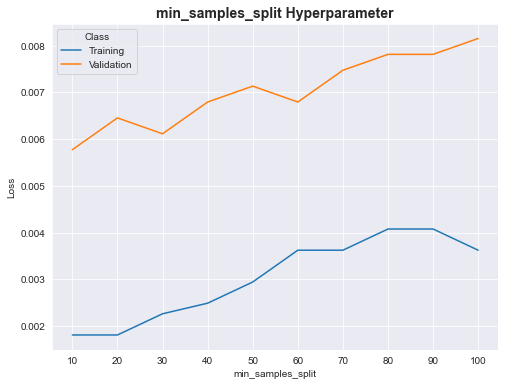

In [62]:
# # #Generate plot
x_ticks = np.arange(0, len(min_samples_split))
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,6));
sns.lineplot(data=[train_loss, validation_loss], dashes=False, ax=ax)
ax.set_title('min_samples_split Hyperparameter', fontsize=14, fontweight='bold');
ax.set(xlabel='min_samples_split', ylabel='Loss');
ax.legend(title='Class', labels=['Training', 'Validation']);
plt.xticks(ticks=x_ticks, labels=min_samples_split);
# plt.savefig('../tuning/exp2_rf_min_samples_split.png', dpi=300)

In [25]:
# # hyperparamer tuning
param_grid = {
    'n_estimators' :[25, 50, 75, 100],
    'criterion': ['gini'],
    'max_leaf_nodes': [4,6,8],
    'max_depth' : [4,5,6],
    'min_samples_split': [20,25,30],
    'max_features': ["sqrt"],
     'bootstrap' : [True],
    }
rf = RandomForestClassifier(random_state=99)
rfgrid = GridSearchCV(rf,param_grid,verbose =1,cv=5)
rfgrid.fit(X_train,y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=99),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [4, 5, 6], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [4, 6, 8],
                         'min_samples_split': [20, 25, 30],
                         'n_estimators': [25, 50, 75, 100]},
             verbose=1)

In [26]:
print(f'Best paramater:  {rfgrid.best_params_}')
print(f'Best score: {(rfgrid.best_score_ * 100):.3f} %')

Best paramater:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 8, 'min_samples_split': 20, 'n_estimators': 50}
Best score: 98.958 %


In [27]:
rf = RandomForestClassifier(
    n_estimators=rfgrid.best_params_["n_estimators"],
    criterion="gini", 
    max_depth= rfgrid.best_params_["max_depth"], 
    max_leaf_nodes= rfgrid.best_params_["max_leaf_nodes"],
    min_samples_split = rfgrid.best_params_['min_samples_split'],
    bootstrap=True, 
    max_features="sqrt",
    random_state=1
) 


In [28]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': 8,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [29]:
# evaluating the models

In [30]:

def sensitivity(conf):
 return conf[1][1] / (conf[1][1] + conf[1][0])

def specificity(conf):
 return conf[0][0] / (conf[0][0] + conf[0][1]) 


In [31]:
def evaluate_model(X, y):

    train_accuracy = []
    test_accuracy = []
    sensitivity_scores = []
    specificity_scores = []
    confusion_matrix_scores = []
    precision_scores = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
    for train, test in  cv.split(X,y):
        X_train_strat = X.iloc[train]
        y_train_strat = y.iloc[train]
        X_test_strat = X.iloc[test]
        y_test_strat = y.iloc[test]
         
        rf.fit(X_train_strat, y_train_strat)
        #Compute accuracy on the training set and test set
        y_pred_train_strat = rf.predict(X_train_strat)
        y_pred_strat = rf.predict(X_test_strat)


        train_accuracy.append(accuracy_score(y_train_strat, y_pred_train_strat))
        test_accuracy.append(accuracy_score(y_test_strat, y_pred_strat))

        conf = confusion_matrix(y_test_strat,y_pred_strat)

        confusion_matrix_scores.append(conf) 

        precision_scores.append(precision_score(y_test_strat,y_pred_strat))
        sensitivity_scores.append(sensitivity(conf))
        specificity_scores.append(specificity(conf))

    return (train_accuracy, test_accuracy, confusion_matrix_scores, 
            precision_scores,sensitivity_scores, 
            specificity_scores)


In [32]:
train_accuracy, test_accuracy, confusion_matrix_scores, precision_scores, sensitivity_scores,specificity_scores = evaluate_model(X, y)

In [33]:
def average(array):
    total = 0
    for score in array:
        total += score

    return (f'{(total / 5 * 100):.2f}')

def score(array):
    for score in array:
        print(f'{(score * 100):.2f}') 

In [34]:
score(train_accuracy)
average(train_accuracy)


98.73
98.52
98.66
98.54
98.59


'98.61'

In [35]:
score(test_accuracy)
average(test_accuracy)

98.57
97.89
98.30
99.12
98.71


'98.52'

In [36]:
for cf in confusion_matrix_scores:
    print(cf , "\n")

[[734   2]
 [ 19 717]] 

[[732   4]
 [ 27 709]] 

[[731   5]
 [ 20 716]] 

[[734   2]
 [ 11 724]] 

[[734   1]
 [ 18 718]] 



In [37]:
# precision_scores
score(precision_scores)
average(precision_scores)

99.72
99.44
99.31
99.72
99.86


'99.61'

In [38]:
# sensitivity_scores
score(sensitivity_scores)
average(sensitivity_scores)

97.42
96.33
97.28
98.50
97.55


'97.42'

In [39]:
# specificity_scores
score(specificity_scores)
average(specificity_scores)

99.73
99.46
99.32
99.73
99.86


'99.62'